# ImagePDF - wmin (Full Covmat + Mini Batch Training)

In [1]:
import itertools

import numpy as np
import numpy.random as npr

import jax.numpy as jnp
import jax

from jax.example_libraries import optimizers

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys.commondataparser import load_commondata

from reportengine import collect


import pandas as pd
from validphys.core import DataGroupSpec

from validphys.pdfbases import evolution
from validphys import convolution
from validphys import covmats
from validphys.loader import Loader

import jax.scipy.linalg as jla



In [2]:
inp = {
    "fit": "210713-n3fit-001",
    "dataset_inputs": {"from_": "fit"},
    "use_cuts": "internal",
    "theoryid": 400
}

In [3]:
data = API.data(**inp)

In [4]:
# store grids with shape (50,) only
xx = []

excluded = set()
included = set()

for ds in data.datasets:

    for fk in ds.fkspecs:

        xgrid = load_fktable(fk).xgrid
        
        if xgrid.shape != (50,):
            print("Excluding", ds)
            excluded.add(ds)
            continue
        else:
            xx.append(xgrid)
            included.add(ds)
included = list(included)

Excluding ATLAS_1JET_8TEV_R06_DEC
Excluding ATLAS_2JET_7TEV_R06
Excluding CMS_2JET_7TEV
Excluding CMS_1JET_8TEV


In [5]:
from jax.tree_util import register_pytree_node_class

# Idea: register class as pytree so that data_stream batches can be passed
# to jax.jit compiled functions
# note that the arguments of the constructor of DataGroupSpec are also classes
# these should therefore be registered as pytree classes as well
# this is not trivial to achieve


@register_pytree_node_class
class FilteredDataGroupSpec(DataGroupSpec):
    """
    """


    def tree_flatten(self):
        """
        """
        children = (self.name , self.datasets, self.dsinputs ) #(self.name,jaxify_datasets(self.datasets), jaxify_datasets(self.dsinputs)) 
        aux_data = None
        return (children, aux_data)
    
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        """ 
        """
        return cls(*children)
    
    def data_stream(self, size=1,seed = 0):
        """yield a DataGroupSpec that contains 1 or more DataSetSpecs

        Parameters
        ----------
        size : int, default value is 1
            number of datasets to include in batch
        
        seed : int, default value is 0
            seed used to set RandomState. Useful for reproducibility.
        
        Yields
        ------
        DataGroupSpec
        """
        
        # this is no longer needed
#         rng = npr.RandomState(seed)

        while True:

            # index of datasets, generate unique random integers
            seq = np.arange(0, len(self.datasets)-1)
            
            # random shuffle should probably take a seed for reproducibility
            np.random.shuffle(seq)
            ds_idx = seq[:size]
#             ds_idx = rng.randint(low=0,high = len(self.datasets)-1,size = size)
            
            ds_specs = np.array(self.datasets)[ds_idx]

            filt_data_batch = FilteredDataGroupSpec(name = "data_batch", datasets = tuple(ds_specs), dsinputs = ds_specs)

            yield filt_data_batch


        
        
filtered_data = FilteredDataGroupSpec(name = "data", datasets = tuple(included), dsinputs = included)

flat, tree = filtered_data.tree_flatten()
unflattened = filtered_data.tree_unflatten(tree, flat)

In [7]:
# batches iterator can be called like this
batches = filtered_data.data_stream(size=0)

data_batches = next(batches)
data_batches

FilteredDataGroupSpec(name='data_batch', datasets=())

In [8]:
# test the all the x grids are the same
arr = np.array(xx)
arr.std(axis=0).max()

1.3322676295501878e-15

In [9]:
# TODO: Is this needed? -> probably no need to jit compile
# jit: just-in-time (JIT) compilation decorator
# compile functions
OP = {key: jax.jit(val) for key,val in convolution.OP.items()}

In [10]:
rng = jax.random.PRNGKey(0xDEADBEEF)

In [11]:
l = Loader()
pdf = l.check_pdf("210713-n3fit-001")

# shape (101, 14, 50)
# LinearBasis Class - > implements basis transformation from flavour to any?
# grid_values: Evaluate ``x*f(x)`` on a grid of points in flavour, x and Q.

INPUT_GRID = evolution.grid_values(pdf, convolution.FK_FLAVOURS, xx[0], [1.65]).squeeze(-1)

# initial weights for weight minimization
weight_base_num = jax.random.normal(rng, shape=(INPUT_GRID.shape[0],))
weight_base = weight_base_num/jnp.sum(weight_base_num)

LHAPDF 6.4.0 loading all 101 PDFs in set 210713-n3fit-001
210713-n3fit-001, version 1; 101 PDF members


## Prediction Functions

In [12]:
def make_dis_prediction(fk):
    """
    TODO
    
    Parameters
    ----------
    fk : 
    
    Returns
    -------
    
    
    """
    indices = fk.luminosity_mapping
    fk_arr = jnp.array(fk.get_np_fktable())
    
    @jax.jit
    def dis_prediction(pdf):
        """
        Compute theory prediction as
        
        T_i = FK_{i,a,x} f_{a,x}
        
        summing over repeated indices
        
        Parameters
        ----------
        pdf : 
        
        """
        return jnp.einsum("ijk, jk ->i", fk_arr, pdf[indices, :])
    return dis_prediction
    
    
def make_had_prediction(fk):
    indices = fk.luminosity_mapping
    first_indices = indices[0::2]
    second_indices = indices[1::2]
    fk_arr = jnp.array(fk.get_np_fktable())
    @jax.jit
    def had_prediction(pdf):
        return jnp.einsum("ijkl,jk,jl->i", fk_arr, pdf[first_indices,:], pdf[second_indices,:])
    return had_prediction


def make_pred_dataset(dataset):
    """
    """
    
    pred_funcs = []
    
    # why does each dataset have several fkspecs?
    # e.g. compound has two fkspec?
    
    for fkspec in dataset.fkspecs:
        fk = load_fktable(fkspec).with_cuts(dataset.cuts)
        if fk.hadronic:
            pred = make_had_prediction(fk)
        else:
            pred = make_dis_prediction(fk)
        pred_funcs.append(pred)
    @jax.jit
    def prediction(pdf):
        return OP[dataset.op](*[f(pdf) for f in pred_funcs])
    
    return prediction


def make_pred_data(data):
    """same as make_pred_datasets but for DataGroupSpec
    
    Parameters
    ----------
    data : DataGroupSpec
    
    Returns
    -------
    jnp.array
    
    """
    
    predictions = []
    for ds in data.datasets:
        predictions.append(make_pred_dataset(ds))
        
    @jax.jit
    def eval_preds(pdf):
        return jnp.array(list(itertools.chain(*[f(pdf) for f in predictions])))

    return eval_preds

In [13]:
m_p_d = make_pred_data(filtered_data)

## Loss functions

In [210]:
def make_chi2(ds):
    """
    
    """
    cd = load_commondata(ds.commondata).with_cuts(ds.cuts)

    central_value = jnp.array(cd.central_values)

    covmat = covmats.covmat_from_systematics(cd, dataset_input=ds)

    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))

    pred = make_pred(ds)
    
    @jax.jit
    def chi2(pdf):
        diff = pred(pdf) - central_value
        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2


def make_chi2_data(data):
    """
    
    Parameters
    ----------
    data : DataGroupSpec
    
    """

    cd_list = data.load_commondata_instance()

    central_values = [cd.central_values for cd in cd_list]
    
    central_values = jnp.array(pd.concat(central_values, axis=0))

    covmat = covmats.dataset_inputs_covmat_from_systematics(cd_list, data_input=data.dsinputs)
    
    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))
    
    pred = make_pred_data(data) 
    
    @jax.jit
    def chi2(pdf):
        diff = pred(pdf) - central_values
        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2

import time

def make_chi2_data_batch(data_batch):
    """
    
    Parameters
    ----------
    data : DataGroupSpec
    
    """
    t0=time.time()
    cd_list = data_batch.load_commondata_instance()

    central_values = [cd.central_values for cd in cd_list]

    central_values = jnp.array(pd.concat(central_values, axis=0))

    covmat = covmats.dataset_inputs_covmat_from_systematics(cd_list, data_input=data_batch.dsinputs)

    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))

    pred = make_pred_data(data_batch) 
    t1 = time.time()
    print(f"Time spent on Validphys stuff = {t1-t0}")

    @jax.jit
    def chi2(pdf):
        diff = pred(pdf) - central_values
        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2

def make_chi2_data_mini_batch(data):
    """
    
    """
    cd_list = data.load_commondata_instance()

    central_values = [cd.central_values for cd in cd_list]
    
    central_values = jnp.array(pd.concat(central_values, axis=0))

    covmat = covmats.dataset_inputs_covmat_from_systematics(cd_list, data_input=data.dsinputs)
    
    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))
    
    pred = make_pred_data(data) 
    
    @jax.jit
    def chi2(pdf,batch_idx):
        """
        TODO
        """
        diff = pred(pdf)[batch_idx] - central_values[batch_idx]

        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat[batch_idx][:,batch_idx], diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2


# chi2_contribs_data = make_chi2_data(filtered_data)
# chi2_contribs_data_mini_batch = make_chi2_data_mini_batch(filtered_data)

# @jax.jit
# def loss_data(weights,data_batch):
#     pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
#     return make_chi2_data(data_batch)(pdf) #chi2_contribs_data(pdf)



In [15]:
batches = filtered_data.data_stream(size = 1)
make_chi2_data_batch(next(batches))

<CompiledFunction of <function make_chi2_data_batch.<locals>.chi2 at 0x18999f4c0>>

In [21]:
data_batch = filtered_data.data_stream(size = 1)

t = [next(data_batch) for i in range(2)]

In [71]:
import time
epochs = 300

batches = filtered_data.data_stream(size = 4)
t0 = time.time()

chi2_batches = []
data_batches = []
for i in range(epochs):
    
    data_batch = next(batches)

    data_batches.append(data_batch)
    chi2_batches.append(make_chi2_data_batch(data_batch))
    

t1 = time.time()
print(f"time needed for {epochs} chi2 batches = {t1-t0}sec")

time needed for 300 chi2 batches = 290.5631957054138sec


In [82]:
# loss and update functions for data batches
# general idea: the architecture should be such that arrays only are passed to jax compiled functions
# in order to do so, we probably need to wrap the loss batch into a function


# @jax.jit
# def loss_batch(weights, chi2_batch):
#     pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
#     return chi2_batch(pdf)# sum([chi2_batch(pdf) for chi2_batch in chi2_batches])

# @jax.jit
# def update_batch(step,opt_state,chi2_batch):
#     params  = get_params(opt_state)
#     return opt_update(step, jax.grad(loss_data)(params,chi2_batch),opt_state)

from functools import partial
# @jax.jit
@partial(jax.jit, static_argnums=1)
def loss_batch(weights, batch_index):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_batches[batch_index](pdf)# sum([chi2_batch(pdf) for chi2_batch in chi2_batches])

# @jax.jit
@partial(jax.jit, static_argnums=2)
def update_batch(step,opt_state,batch_index):
    params  = get_params(opt_state)
    return opt_update(step, jax.grad(loss_batch)(params,batch_index),opt_state)


In [229]:

def loss_batch(weights,data_batch):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    @jax.jit
    def wrap_loss_batch(pdf):
        return make_chi2_data_batch(data_batch)(pdf)
    
    return wrap_loss_batch(pdf)


def update_batch(weights,step,opt_state,data_batch):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    @jax.jit
    def wrap_update_batch(pdf):
        params  = get_params(opt_state)
        return opt_update(step, jax.grad(loss_batch)(params,data_batch) ,opt_state)
    
    return wrap_update_batch(pdf)


In [230]:
momentum_mass = 0.9

step_size = 1e-8

num_epochs = 50

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass = momentum_mass)

In [231]:
batches = filtered_data.data_stream(size = 2)

In [232]:
opt_counter = itertools.count()
opt_state = opt_init(weight_base)


loss = []
for i in range(num_epochs):
    t0 = time.time()
    data_batch = next(batches)
    cd_list = data_batch.load_commondata_instance()
    ndata = sum([cd.ndata for cd in cd_list])
      
    weights = get_params(opt_state)
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)

    lss = loss_batch(get_params(opt_state), data_batch) / ndata
    loss.append(lss)
    print(f"Epoch {i}, loss {lss:.3f},\
            datasets = {[ds.name for ds in data_batches[i].datasets]}, ndata = {ndata}")
    
    opt_state = update_batch(weights,next(opt_counter), opt_state, data_batch)
    t1 = time.time()
    print(f"Time spent per loop = {t1-t0}")

Time spent on Validphys stuff = 0.09984683990478516
Epoch 0, loss 0.751,            datasets = ['HERACOMBNCEM', 'ATLASZHIGHMASS49FB', 'CDFZRAP_NEW', 'ATLAS_SINGLETOP_TCH_R_7TEV'], ndata = 21
Time spent on Validphys stuff = 0.08798480033874512
Time spent per loop = 1.3390147686004639
Time spent on Validphys stuff = 0.2013261318206787
Epoch 1, loss 0.636,            datasets = ['HERACOMBNCEP575', 'ATLASWZRAP11CF', 'ATLASZPT8TEVMDIST', 'CMSTTBARTOT13TEV'], ndata = 52
Time spent on Validphys stuff = 0.17455220222473145
Time spent per loop = 1.1907069683074951
Time spent on Validphys stuff = 0.04670000076293945
Epoch 2, loss 0.621,            datasets = ['LHCBZ940PB', 'ATLAS_SINGLETOP_TCH_DIFF_7TEV_T_RAP_NORM', 'CMS_SINGLETOP_TCH_R_13TEV', 'CMS_TTB_DIFF_13TEV_2016_2L_TRAP'], ndata = 13
Time spent on Validphys stuff = 0.04668116569519043
Time spent per loop = 0.708698034286499
Time spent on Validphys stuff = 1.213818073272705
Epoch 3, loss 1.358,            datasets = ['CMS_TTB_DIFF_13TEV_20

Time spent on Validphys stuff = 0.7808589935302734
Time spent per loop = 3.523620128631592
Time spent on Validphys stuff = 0.1802229881286621
Epoch 29, loss 2.004,            datasets = ['ATLASTTBARTOT8TEV', 'ATLASWZRAP11CC', 'CMSTOPDIFF8TEVTTRAPNORM', 'CMS_TTBAR_2D_DIFF_MTT_TRAP_NORM'], ndata = 38
Time spent on Validphys stuff = 0.17391204833984375
Time spent per loop = 1.248509168624878
Time spent on Validphys stuff = 0.12681198120117188
Epoch 30, loss 1.440,            datasets = ['CMSTOPDIFF8TEVTTRAPNORM', 'HERACOMBNCEP920', 'CMSTTBARTOT13TEV', 'ATLASWZRAP11CC'], ndata = 43
Time spent on Validphys stuff = 0.12425494194030762
Time spent per loop = 1.0687651634216309
Time spent on Validphys stuff = 0.04917407035827637
Epoch 31, loss 0.725,            datasets = ['CMS_SINGLETOP_TCH_TOT_7TEV', 'LHCB_Z_13TEV_DIELECTRON', 'CMSTOPDIFF8TEVTTRAPNORM', 'CMSWMASY47FB'], ndata = 12
Time spent on Validphys stuff = 0.048011064529418945
Time spent per loop = 0.7290349006652832
Time spent on Valid

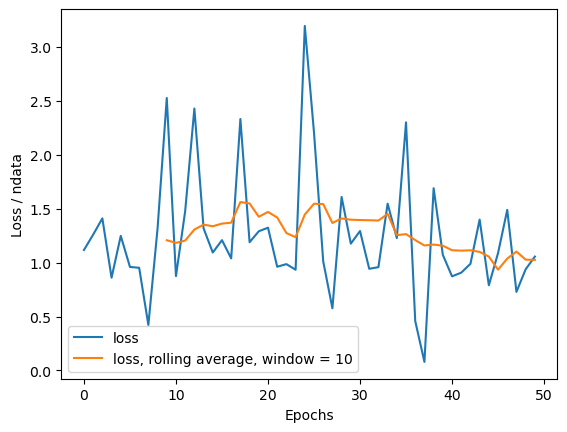

In [224]:
import matplotlib.pyplot as plt
import pandas as pd


loss = np.array(loss)
df = pd.DataFrame({"loss":loss})

fig, ax = plt.subplots()

ax.plot(loss, label = "loss")
wind_size = 10
ax.plot(df.rolling(wind_size).mean().to_numpy(), label = f"loss, rolling average, window = {wind_size}")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss / ndata")
ax.legend()

## mini batch gradient descendt

In [16]:
# loss_data should take array of chi2 functions each of which is for a
# different data batch

# @jax.jit
def loss_data(weights,data_batch):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return make_chi2_data(data_batch)(pdf) #chi2_contribs_data(pdf)

### Train model using jax optimizers example library

In [48]:
momentum_mass = 0.9

step_size = 1e-8

num_epochs = 150

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass = momentum_mass)
# opt_init, opt_update, get_params = optimizers.adagrad(step_size, momentum = momentum_mass)

In [49]:
# @jax.jit
def update(step,opt_state,data_batch):
    params  = get_params(opt_state)
    return opt_update(step, jax.grad(loss_data)(params,data_batch),opt_state)

In [50]:
opt_counter = itertools.count()
opt_state = opt_init(weight_base)
loss = []
batches = filtered_data.data_stream(size=6)

for epoch in range(num_epochs):
    # get data batch from generator
    data_batch = next(batches)
    
#     Convert the data batch to a JAX-compatible format
#     data_batch = jax.tree_util.tree_map(jax.device_put, data_batch)


    cd_list = data_batch.load_commondata_instance()
    ndata = sum([cd.ndata for cd in cd_list])

    print(f"Epoch {epoch}, loss {loss_data(get_params(opt_state),data_batch) / ndata :.3f}, \
      datasets = {[ds.name for ds in data_batch.datasets]}, ndata = {ndata}")
    loss.append(loss_data(get_params(opt_state),data_batch) / ndata)
    
    opt_state = update(next(opt_counter), opt_state, data_batch)

Epoch 0, loss 1.193,       datasets = ['ATLASZHIGHMASS49FB', 'HERACOMBNCEP460', 'ATLASWZRAP11CF', 'ATLAS_TTB_DIFF_8TEV_LJ_TRAPNORM', 'HERACOMB_SIGMARED_B', 'LHCBZ940PB'], ndata = 263
Epoch 1, loss 1.321,       datasets = ['HERACOMBNCEP460', 'ATLASWZRAP11CC', 'HERACOMBNCEP920', 'ATLAS_SINGLETOP_TCH_DIFF_8TEV_T_RAP_NORM', 'LHCBZ940PB', 'CMSZDIFF12'], ndata = 667
Epoch 2, loss 1.288,       datasets = ['BCDMSP_dwsh', 'ATLASZPT8TEVMDIST', 'CDFZRAP_NEW', 'ATLAS_DY_2D_8TEV_LOWMASS', 'SLACP_dwsh', 'ATLAS_TTBARTOT_13TEV_FULLLUMI'], ndata = 499
Epoch 3, loss 1.429,       datasets = ['CMS_TTBAR_2D_DIFF_MTT_TRAP_NORM', 'D0ZRAP_40', 'CDFZRAP_NEW', 'LHCBWZMU7TEV', 'ATLASZHIGHMASS49FB', 'ATLAS_SINGLETOP_TCH_R_13TEV'], ndata = 106
Epoch 4, loss 1.123,       datasets = ['HERACOMBCCEM', 'NTVNBDMNFe_dw_ite', 'ATLAS_SINGLETOP_TCH_R_7TEV', 'CMS_TTBAR_2D_DIFF_MTT_TRAP_NORM', 'HERACOMB_SIGMARED_B', 'HERACOMBNCEP820'], ndata = 191
Epoch 5, loss 1.098,       datasets = ['ATLASPHT15_SF', 'HERACOMB_SIGMARED_B', 

Epoch 46, loss 1.251,       datasets = ['DYE886P', 'HERACOMBNCEP575', 'HERACOMBNCEP920', 'CMSWEASY840PB', 'ATLAS_SINGLETOP_TCH_R_13TEV', 'CDFZRAP_NEW'], ndata = 760
Epoch 47, loss 1.053,       datasets = ['CMS_SINGLETOP_TCH_R_13TEV', 'HERACOMBCCEP', 'ATLASZHIGHMASS49FB', 'HERACOMB_SIGMARED_C', 'CHORUSNBPb_dw_ite', 'CMSTTBARTOT7TEV'], ndata = 499
Epoch 48, loss 1.241,       datasets = ['CMSDY2D11', 'ATLAS_WZ_TOT_13TEV', 'HERACOMBNCEP820', 'DYE605_dw_ite', 'CMSTTBARTOT5TEV', 'CMSTTBARTOT7TEV'], ndata = 270
Epoch 49, loss 1.409,       datasets = ['DYE906R_dw_ite', 'ATLASPHT15_SF', 'LHCBZEE2FB_40', 'ATLASWZRAP36PB', 'BCDMSP_dwsh', 'BCDMSD_dw_ite'], ndata = 687
Epoch 50, loss 1.281,       datasets = ['CMS_TTB_DIFF_13TEV_2016_2L_TRAP', 'ATLASPHT15_SF', 'NMCPD_dw_ite', 'CMS_SINGLETOP_TCH_R_8TEV', 'HERACOMBNCEP920', 'ATLASZPT8TEVYDIST'], ndata = 610
Epoch 51, loss 1.795,       datasets = ['CMSTTBARTOT7TEV', 'D0WMASY', 'HERACOMB_SIGMARED_C', 'ATLAS_WP_JET_8TEV_PT', 'CMS_TTBAR_2D_DIFF_MTT_TRAP_N

Epoch 90, loss 1.167,       datasets = ['DYE886R_dw_ite', 'ATLAS_TTBARTOT_13TEV_FULLLUMI', 'CMSDY2D11', 'BCDMSD_dw_ite', 'ATLAS_DY_2D_8TEV_LOWMASS', 'ATLAS_SINGLETOP_TCH_DIFF_8TEV_T_RAP_NORM'], ndata = 437
Epoch 91, loss 0.962,       datasets = ['CMS_SINGLETOP_TCH_TOT_7TEV', 'CMSTTBARTOT5TEV', 'ATLASTTBARTOT8TEV', 'ATLAS_TTBARTOT_13TEV_FULLLUMI', 'CHORUSNUPb_dw_ite', 'ATLASPHT15_SF'], ndata = 473
Epoch 92, loss 1.293,       datasets = ['ATLAS_DY_2D_8TEV_LOWMASS', 'ATLAS_SINGLETOP_TCH_R_7TEV', 'ATLASWZRAP36PB', 'CMSTTBARTOT8TEV', 'ATLAS_SINGLETOP_TCH_R_13TEV', 'ATLAS_SINGLETOP_TCH_DIFF_8TEV_TBAR_RAP_NORM'], ndata = 96
Epoch 93, loss 1.175,       datasets = ['CMSTOPDIFF8TEVTTRAPNORM', 'ATLASWZRAP11CC', 'BCDMSD_dw_ite', 'DYE906R_dw_ite', 'ATLASZPT8TEVYDIST', 'CDFZRAP_NEW'], ndata = 385
Epoch 94, loss 1.262,       datasets = ['SLACD_dw_ite', 'ATLAS_TOPDIFF_DILEPT_8TEV_TTRAPNORM', 'ATLASWZRAP11CF', 'ATLAS_WM_JET_8TEV_PT', 'DYE886P', 'ATLASPHT15_SF'], ndata = 210
Epoch 95, loss 1.297,       

Epoch 134, loss 1.388,       datasets = ['NTVNBDMNFe_dw_ite', 'DYE886P', 'ATLAS_WZ_TOT_13TEV', 'LHCBWZMU7TEV', 'CMS_TTB_DIFF_13TEV_2016_2L_TRAP', 'DYE906R_dw_ite'], ndata = 174
Epoch 135, loss 1.413,       datasets = ['ATLAS_SINGLETOP_TCH_R_13TEV', 'HERACOMBNCEP460', 'CMSWMASY47FB', 'ATLAS_TTB_DIFF_8TEV_LJ_TTRAPNORM', 'ATLAS_SINGLETOP_TCH_R_7TEV', 'ATLAS_DY_2D_8TEV_LOWMASS'], ndata = 281
Epoch 136, loss 0.954,       datasets = ['DYE906R_dw_ite', 'BCDMSD_dw_ite', 'NMCPD_dw_ite', 'ATLAS_TTBARTOT_13TEV_FULLLUMI', 'HERACOMBNCEP575', 'CMSTTBARTOT8TEV'], ndata = 631
Epoch 137, loss 1.287,       datasets = ['HERACOMBNCEP920', 'HERACOMBCCEM', 'ATLASWZRAP11CF', 'SLACD_dw_ite', 'CMS_TTB_DIFF_13TEV_2016_LJ_TRAP', 'ATLAS_TOPDIFF_DILEPT_8TEV_TTRAPNORM'], ndata = 483
Epoch 138, loss 0.903,       datasets = ['CMSTTBARTOT5TEV', 'NTVNBDMNFe_dw_ite', 'SLACD_dw_ite', 'LHCBZEE2FB_40', 'ATLASWZRAP36PB', 'DYE886R_dw_ite'], ndata = 134
Epoch 139, loss 1.099,       datasets = ['HERACOMBCCEM', 'CHORUSNUPb_dw_i

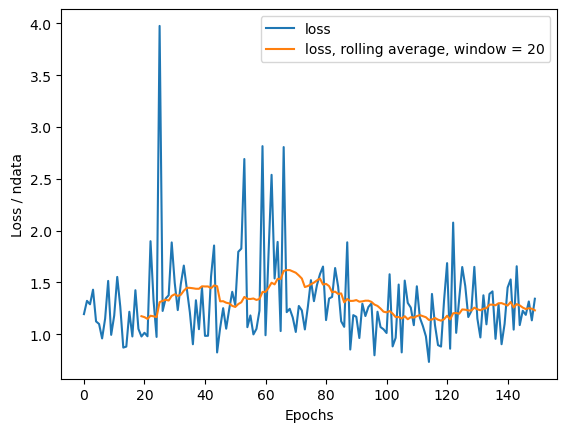

In [63]:
import matplotlib.pyplot as plt
import pandas as pd


loss = np.array(loss)
df = pd.DataFrame({"loss":loss})

fig, ax = plt.subplots()

ax.plot(loss, label = "loss")
wind_size = 20
ax.plot(df.rolling(wind_size).mean().to_numpy(), label = f"loss, rolling average, window = {wind_size}")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss / ndata")
ax.legend()


In [28]:
jax.tree_util.

<function jax._src.tree_util.tree_map(f: Callable[..., Any], tree: Any, *rest: Any, is_leaf: Optional[Callable[[Any], bool]] = None) -> Any>

# Old

In [23]:
@jax.jit
def loss_data_batch(weights,batch_idx):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_contribs_data_mini_batch(pdf,batch_idx)

In [77]:
def data_stream(size=1):
    """
    Could be a method of the FilteredDataGroupSpec class
    
    yield a DataGroupSpec that contains 1 or
    more DataSetSpecs

    Parameters
    ----------
    size : int, default value is 1
        number of datasets to include in batch
        
    Yields
    ------
    DataGroupSpec
    
    """
    
    rng = npr.RandomState(0)
    
    
    while True:
        
        # index of datasets
        ds_idx = rng.randint(low=0,high = len(data.datasets)-1,size = size)
        ds_specs = np.array(filtered_data.datasets)[ds_idx]
        
        filt_data_batch = FilteredDataGroupSpec(name = "data_batch", datasets = tuple(ds_specs), dsinputs = ds_specs)
        
        yield filt_data_batch
            
batches = data_stream(size=2)

In [48]:
rng.randint(low=0,high=len(data.datasets)-1,size = 2)

array([64, 67])

In [24]:
import numpy as np

# is bugged as it does not always yield batches of the same shape

def random_subset(Ndat, batch_size):
    """
    Yield a generator for random mini-batches of indices of size `batch_size` from an array of size `Ndat`
    """
    while True:
        # generate a random permutation of indices
        perm = np.random.permutation(Ndat)
        
        # create mini-batches of size `batch_size`
        for i in range(0, Ndat, batch_size):
            yield perm[i:i+batch_size]

# Example
# set the parameters
batch_size = 10

# initialize the random mini-batch generator
batch_index = random_subset(Ndat, batch_size)

# get the first mini-batch
mini_batch1 = next(batch_index)
print(mini_batch1)

# get the second mini-batch
mini_batch2 = next(batch_index)
print(mini_batch2)

[3136 2595 3282 2077  298 1754   47 1416 2809 2236]
[ 355  687 2098  894 3955  411 2139 3868 1850  428]


### Train model using jax optimizers example library

In [26]:
# compute grad on mini batch
grad = jax.grad(loss_data_batch)(weight_base,jnp.array([0,1,2,3]))

In [27]:
momentum_mass = 0.9

step_size = 1e-8

num_epochs = 500

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass = momentum_mass)
# opt_init, opt_update, get_params = optimizers.adagrad(step_size, momentum = momentum_mass)

In [28]:
# @jax.jit
# def update(step,opt_state,batch_idx):
#     params  = get_params(opt_state)
#     return opt_update(step, jax.grad(loss_data_batch)(params,batch_idx),opt_state)

@jax.jit
def update(step,opt_state,batch):
    params  = get_params(opt_state)
    return opt_update(step, jax.grad(loss_data)(params,batch),opt_state)

In [29]:
opt_counter = itertools.count()
opt_state = opt_init(weight_base)

batch_size = 15
# batch_iterator = random_neighbouring_subset(Ndat, batch_size)
batch_iterator = random_subset(Ndat, batch_size)

for epoch in range(num_epochs):
    # get batch index from generator
    batch_idx = next(batch_iterator)
    
    print(f"Epoch {epoch}, loss {loss_data_batch(get_params(opt_state),batch_idx):.3f}, \
          len(batch_idx) = {len(batch_idx)}")
    
    opt_state = update(next(opt_counter), opt_state, batch_idx)
    
    

Epoch 0, loss 123.542,           len(batch_idx) = 15
Epoch 1, loss 54.436,           len(batch_idx) = 15
Epoch 2, loss 61.556,           len(batch_idx) = 15
Epoch 3, loss 52.110,           len(batch_idx) = 15
Epoch 4, loss 150.720,           len(batch_idx) = 15
Epoch 5, loss 98.448,           len(batch_idx) = 15
Epoch 6, loss 468.318,           len(batch_idx) = 15
Epoch 7, loss 22.799,           len(batch_idx) = 15
Epoch 8, loss 114.096,           len(batch_idx) = 15
Epoch 9, loss 38.138,           len(batch_idx) = 15
Epoch 10, loss 402.146,           len(batch_idx) = 15
Epoch 11, loss 44.214,           len(batch_idx) = 15
Epoch 12, loss 48.651,           len(batch_idx) = 15
Epoch 13, loss 73.297,           len(batch_idx) = 15
Epoch 14, loss 174.068,           len(batch_idx) = 15
Epoch 15, loss 185.663,           len(batch_idx) = 15
Epoch 16, loss 179.258,           len(batch_idx) = 15
Epoch 17, loss 494.901,           len(batch_idx) = 15
Epoch 18, loss 39.150,           len(batch_idx)

Epoch 153, loss 7824.375,           len(batch_idx) = 15
Epoch 154, loss 5016.576,           len(batch_idx) = 15
Epoch 155, loss 3993.147,           len(batch_idx) = 15
Epoch 156, loss 8323.969,           len(batch_idx) = 15
Epoch 157, loss 4795.538,           len(batch_idx) = 15
Epoch 158, loss 5129.077,           len(batch_idx) = 15
Epoch 159, loss 6022.242,           len(batch_idx) = 15
Epoch 160, loss 8877.090,           len(batch_idx) = 15
Epoch 161, loss 854.756,           len(batch_idx) = 15
Epoch 162, loss 644.113,           len(batch_idx) = 15
Epoch 163, loss 78.751,           len(batch_idx) = 15
Epoch 164, loss 1212.436,           len(batch_idx) = 15
Epoch 165, loss 191.719,           len(batch_idx) = 15
Epoch 166, loss 62.397,           len(batch_idx) = 15
Epoch 167, loss 202.855,           len(batch_idx) = 15
Epoch 168, loss 798.225,           len(batch_idx) = 15
Epoch 169, loss 15111.107,           len(batch_idx) = 15
Epoch 170, loss 137.434,           len(batch_idx) = 15
E

Epoch 310, loss nan,           len(batch_idx) = 15
Epoch 311, loss nan,           len(batch_idx) = 15
Epoch 312, loss nan,           len(batch_idx) = 15
Epoch 313, loss nan,           len(batch_idx) = 15
Epoch 314, loss nan,           len(batch_idx) = 15
Epoch 315, loss nan,           len(batch_idx) = 15
Epoch 316, loss nan,           len(batch_idx) = 15
Epoch 317, loss nan,           len(batch_idx) = 15
Epoch 318, loss nan,           len(batch_idx) = 15
Epoch 319, loss nan,           len(batch_idx) = 15
Epoch 320, loss nan,           len(batch_idx) = 15
Epoch 321, loss nan,           len(batch_idx) = 15
Epoch 322, loss nan,           len(batch_idx) = 15
Epoch 323, loss nan,           len(batch_idx) = 15
Epoch 324, loss nan,           len(batch_idx) = 15
Epoch 325, loss nan,           len(batch_idx) = 15
Epoch 326, loss nan,           len(batch_idx) = 15
Epoch 327, loss nan,           len(batch_idx) = 15
Epoch 328, loss nan,           len(batch_idx) = 15
Epoch 329, loss nan,           

Epoch 473, loss nan,           len(batch_idx) = 15
Epoch 474, loss nan,           len(batch_idx) = 15
Epoch 475, loss nan,           len(batch_idx) = 15
Epoch 476, loss nan,           len(batch_idx) = 15
Epoch 477, loss nan,           len(batch_idx) = 15
Epoch 478, loss nan,           len(batch_idx) = 15
Epoch 479, loss nan,           len(batch_idx) = 15
Epoch 480, loss nan,           len(batch_idx) = 15
Epoch 481, loss nan,           len(batch_idx) = 15
Epoch 482, loss nan,           len(batch_idx) = 15
Epoch 483, loss nan,           len(batch_idx) = 15
Epoch 484, loss nan,           len(batch_idx) = 15
Epoch 485, loss nan,           len(batch_idx) = 15
Epoch 486, loss nan,           len(batch_idx) = 15
Epoch 487, loss nan,           len(batch_idx) = 15
Epoch 488, loss nan,           len(batch_idx) = 15
Epoch 489, loss nan,           len(batch_idx) = 15
Epoch 490, loss nan,           len(batch_idx) = 15
Epoch 491, loss nan,           len(batch_idx) = 15
Epoch 492, loss nan,           

In [71]:
import matplotlib.pyplot as plt

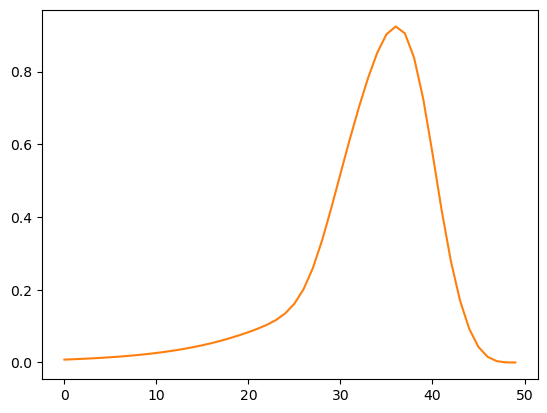

In [105]:
plt.plot(jnp.einsum("i,ijk->jk", get_params(opt_state), INPUT_GRID)[5, :])
plt.plot(INPUT_GRID[0, 5,:])

In [257]:
convolution.FK_FLAVOURS

array(['photon', '\\Sigma', 'g', 'V', 'V3', 'V8', 'V15', 'V24', 'V35',
       'T3', 'T8', 'T15', 'T24', 'T35'], dtype='<U6')

In [216]:
len(chi2_contribs)

73

In [217]:
loss(get_params(opt_state), chi2_contribs)

Array(nan, dtype=float32)

In [ ]:
loss()

In [180]:
ii = iter(batch_stream())

In [16]:


cd = load_commondata(ds.commondata).with_cuts(ds.cuts)

central_value = jnp.array(cd.central_values)

covmat = covmats.covmat_from_systematics(cd, dataset_input=ds)



sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))

jnp.sum(jla.solve_triangular(sqrt_covmat, central_value, lower=True)**2)





No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(43581.004, dtype=float32)

In [191]:
next(ii)

[<PjitFunction of <function make_chi2.<locals>.chi2 at 0x7fa188021940>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badeea160>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9d2d025a60>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9e01c2b790>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9bade95160>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9bade67ca0>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badee85e0>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badef3040>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9d23cdb700>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badec5ee0>>]

In [101]:
covmats.systematics_matrix_from_commondata??

In [56]:
a = np.random.rand(len(covmat))

In [67]:
import scipy.linalg as la

In [68]:
a@la.inv(covmat)@a

76949.52986563856

In [98]:
jnp.sum(jla.solve_triangular(sqrt_covmat, a, lower=True)**2)

Array(76949.53, dtype=float32)

In [69]:
from validphys.calcutils import calc_chi2

In [70]:
calc_chi2(la.cholesky(covmat, lower=True), a)

76949.52986563857

In [74]:
calc_chi2(covmats.sqrt_covmat(covmat), a)

76949.52986563857

In [76]:
sm = covmats.systematics_matrix_from_commondata(cd, ds)

In [77]:
sm.shape

(121, 226)

In [80]:
q,r = la.qr(sm)

In [81]:
q

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [86]:
la.solve_triangular(r, a)

ValueError: expected square matrix

In [88]:
import matplotlib.pyplot as plt

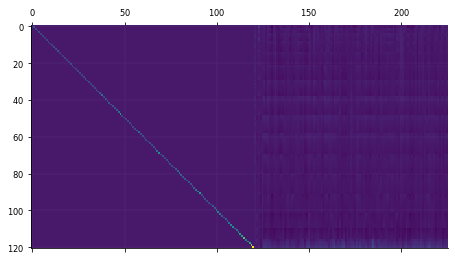

In [90]:
plt.matshow(q@r)

In [66]:
la.cholesky??

In [ ]:
from val

In [48]:
covmat

array([[ 2.68593312e-04,  1.83984561e-04,  7.67906773e-05, ...,
        -7.63211469e-05, -1.05104702e-04, -1.37744623e-04],
       [ 1.83984561e-04,  4.04746250e-04,  6.08510678e-05, ...,
        -1.27447854e-04, -1.71832192e-04, -2.22663390e-04],
       [ 7.67906773e-05,  6.08510678e-05,  1.91100734e-04, ...,
         1.14004879e-04,  1.45105124e-04,  1.87405121e-04],
       ...,
       [-7.63211469e-05, -1.27447854e-04,  1.14004879e-04, ...,
         2.33261176e-03,  1.15595913e-03,  1.43098653e-03],
       [-1.05104702e-04, -1.71832192e-04,  1.45105124e-04, ...,
         1.15595913e-03,  4.07094629e-03,  1.80012082e-03],
       [-1.37744623e-04, -2.22663390e-04,  1.87405121e-04, ...,
         1.43098653e-03,  1.80012082e-03,  6.43026459e-03]])

In [42]:
covmat_from_systematics??

In [23]:
cd.central_values

entry
46     0.9734
47     0.9821
59     0.9716
60     0.9817
61     0.9942
        ...  
256    0.6717
257    0.7194
258    0.6959
259    0.7020
260    0.7724
Name: data, Length: 121, dtype: float64

LHAPDF 6.4.0 loading /home/zah/anaconda3/envs/nnpdfdev/share/LHAPDF/NNPDF40_nlo_as_01180/NNPDF40_nlo_as_01180_0000.dat
NNPDF40_nlo_as_01180 PDF set, member #0, version 1


In [318]:
pdf_base.shape

(14, 50)

In [319]:
vals.shape

(14, 50)

In [320]:
loss(vals, chi2_contribs)

Array(5888.8696, dtype=float32)

In [157]:
def loss(nn):
    return nn - vals

In [158]:
vals.shape

(1, 14, 50)

In [159]:
tb = load_fktable(ds.fkspecs[0])

In [160]:
tb.luminosity_mapping

array([ 1,  1,  1,  2,  1,  3,  1,  4,  1,  5,  1,  6,  1,  9,  1, 10,  1,
       11,  2,  2,  2,  3,  2,  4,  2,  5,  2,  6,  2,  9,  2, 10,  2, 11,
        3,  3,  3,  4,  3,  5,  3,  6,  3,  9,  3, 10,  3, 11,  4,  4,  4,
        5,  4,  6,  4,  9,  4, 10,  4, 11,  5,  5,  5,  6,  5,  9,  5, 10,
        5, 11,  6,  6,  6,  9,  6, 10,  6, 11,  9,  9,  9, 10,  9, 11, 10,
       10, 10, 11, 11, 11])

In [162]:
tb.get_np_fktable().shape

(17, 45, 50, 50)

In [163]:
from jax.example_libraries import stax

In [183]:
init, predict = stax.serial(stax.Dense((2)), stax.Dense((3)))

In [184]:
from jax import random

In [185]:
rng = random.PRNGKey(3)

In [188]:
init(rng, (1,))

((3,),
 [(Array([[-0.99891424,  0.79900575]], dtype=float32),
   Array([0.01032689, 0.01061993], dtype=float32)),
  (Array([[-0.97583795, -0.5411103 , -0.47663605],
          [-1.1263915 , -0.7123102 , -1.2609658 ]], dtype=float32),
   Array([-0.0023886 , -0.00962158,  0.01378133], dtype=float32))])

In [189]:
import numpy as np

In [192]:
initial = np.random.rand(50)

In [193]:
import matplotlib.pyplot as plt

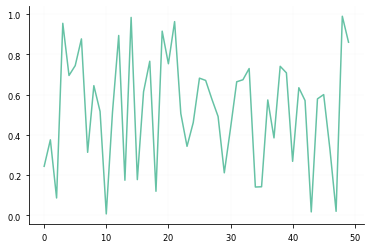

In [194]:
plt.plot(initial)

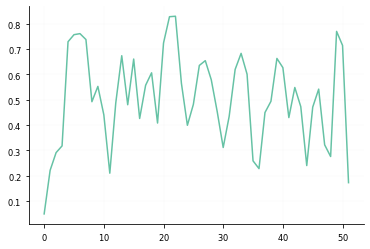

In [197]:
plt.plot(np.convolve(initial, [0.2, 0.6, 0.2]))

In [370]:
from jax.example_libraries import stax

In [373]:
pdf_base.shape

(14, 50)

In [379]:
init, apply = stax.Conv(1, (1,10))

In [380]:
stax.Conv??

In [382]:
init??

In [384]:
init(rng, (14,50,1))

IndexError: tuple index out of range

In [385]:
%debug

> /home/zah/anaconda3/envs/nnpdfdev/lib/python3.9/site-packages/jax/example_libraries/stax.py(76)<listcomp>()
     74     filter_shape_iter = iter(filter_shape)
     75     kernel_shape = [out_chan if c == 'O' else
---> 76                     input_shape[lhs_spec.index('C')] if c == 'I' else
     77                     next(filter_shape_iter) for c in rhs_spec]
     78     output_shape = lax.conv_general_shape_tuple(

ipdb> lhs_spec
'NHWC'
ipdb> q


In [393]:
@jax.jit
def f(obj):
    return obj["inte"]

In [394]:
class X:
    inte = 1

In [395]:
f({"inte":1})

Array(1, dtype=int32, weak_type=True)